## Analyzing Air Quality Trends in the US with EPA AQI Data 
## EDS 220, Fall 2021

## Authors

- Felicia Cruz, UC Santa Barbara (feliciamcruz@bren.ucsb.edu) <br>
  https://fmcruz23.github.io/
- Steven Cognac, UC Santa Barbara (scognac@bren.ucsb.edu) <br>
  
- Grace Lewin, UC Santa Barbara (glewin@bren.ucsb.edu) <br>
  

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
### Notebook Purpose

An example for the Week 7 in-class intensive: <br>
This notebook was created to provide an introduction to using sea surface temperature data from the NOAA Extended Reconstructed SST dataset version 5 (ERSSTv5) for analysis of El Nino/Southern Oscillation (ENSO) behavior.

To assess how air quality has changed over time from 1980 to 2020, we will be using daily Air Quality Index (AQI) data by US county. This data is made available by the US EPA and is freely accessible. 

This notebook was created to assess trends in air quality over time in the United States. Using daily air quality index (AQI) data from the US EPA,


<a id='overview'></a> 
### Dataset Description

This portion of the notebook should contain a summary description of your chosen environmental dataset. In a few paragraphs, discuss:
- The creators of the dataset: NASA/NOAA/other government agency? Nonprofit? etc.
- Major characteristics of the dataset: global coverage? Spatial resolution? Temporal resolution? Creation date? 
- The file format(s) used to store the data: netCDF? CSV? Other?
- The source/archive you will be using to retrieve the data: Google Earth Engine? Agency data portal? Other API?
- Any known issues with data quality that might be expected to impact the results

Include links to any external resources needed to access the data here, including either the location of files stored on an external server you've set up or the access URL for a pre-existing repository. You can also include any example images you find useful for motivating the choice of dataset (optional).

**Here and throughout the notebook:** use a mix of markdown cells and code blocks to demonstrate your code. Markdown cells should be used to describe the purpose of the code blocks which follow them, but _do not replace_ comments within the code block! Make sure to include comments in the code as well illustrating the specific function of the various lines of code. Your later self - and other users - will thank you!

We have chosen to use pre-generated data files from the US EPA for Daily AQI by County and Daily AQI by CBSA which can be found here: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

These datasets include daily AQI readings for each year from 1980-2021, with observations for all 50 states. AQI is calculated using the pollutant with the highest concentration at the time of the reading using the following equation: 
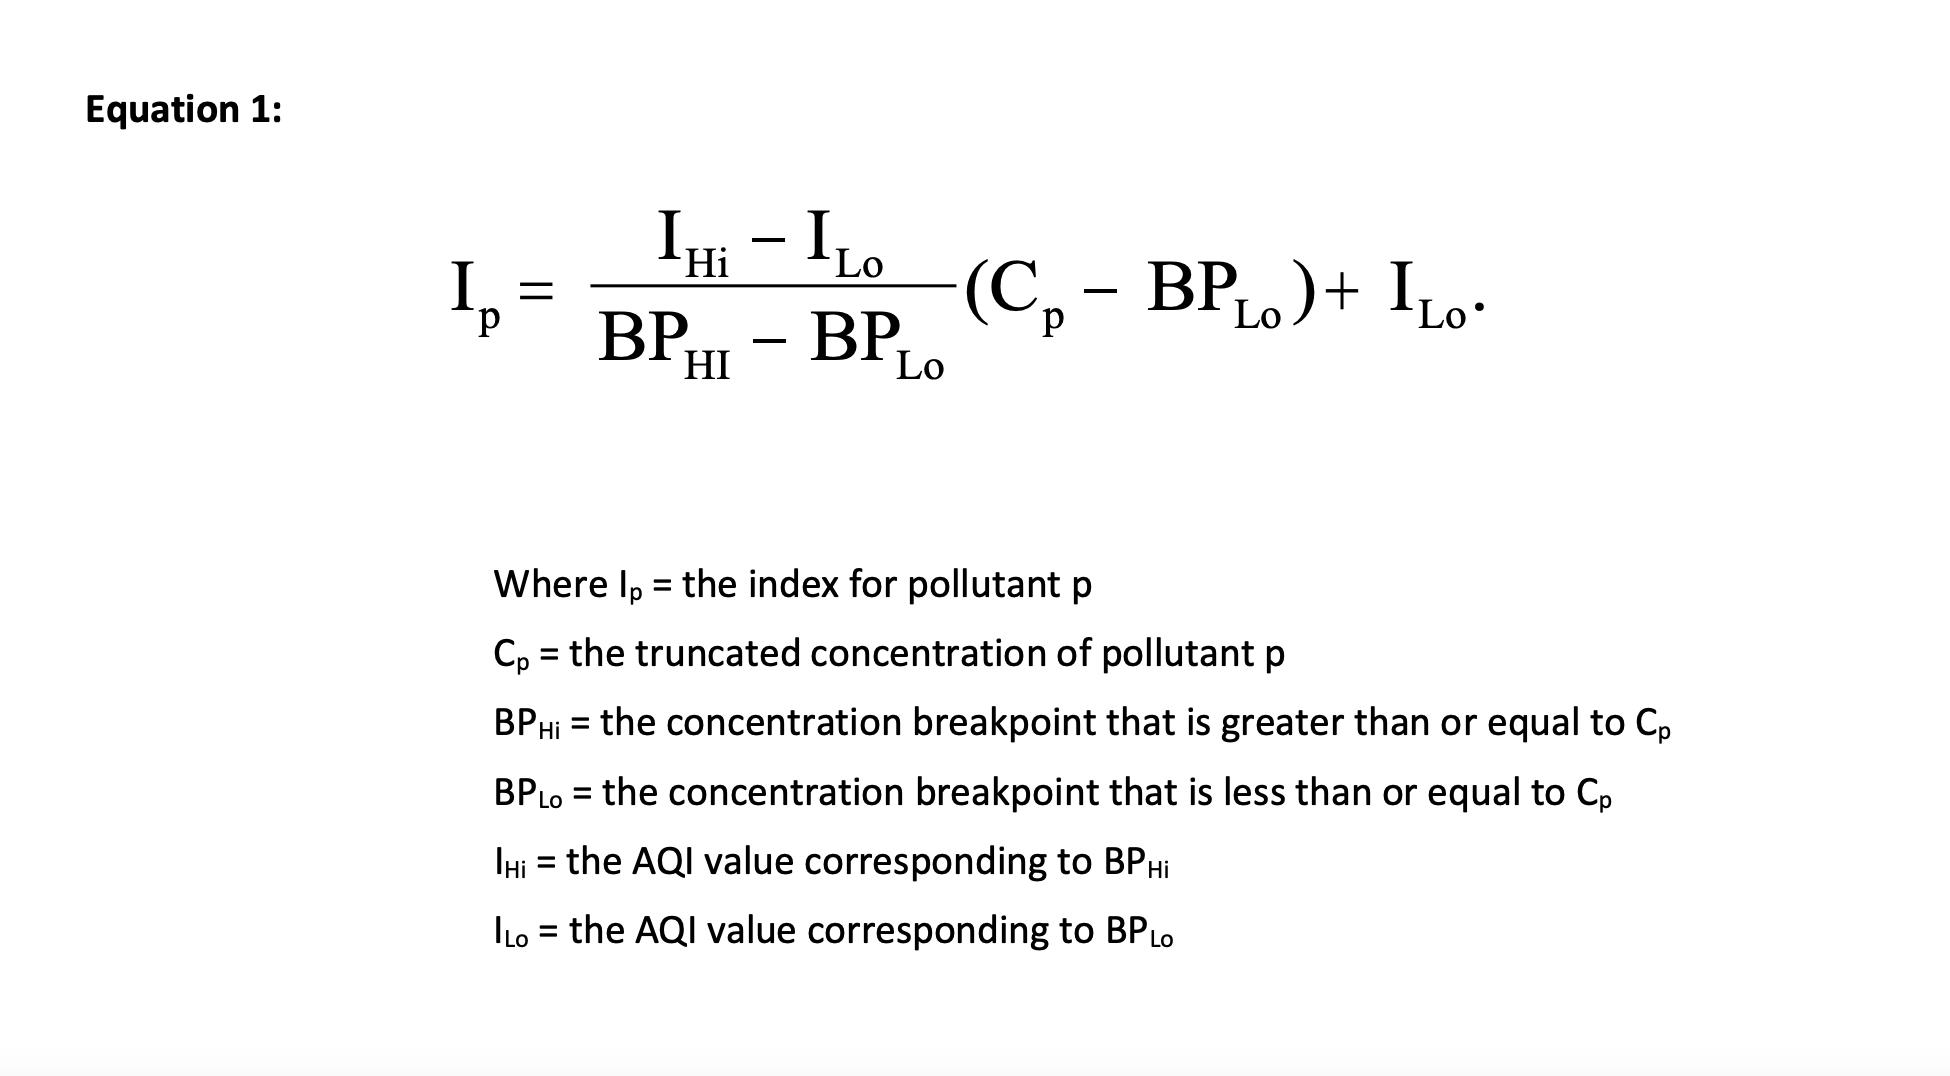

For more information on how AQI is calculated please visit: https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
The six defining parameters that affect the AQI value are Ozone, CO, NO2, SO2, PM 2.5, and PM 10. 


Our files contain a daily summary record that is:

1) The aggregate of all sub-daily measurements taken at the monitor.

2) The single sample value if the monitor takes a single, daily sample (e.g., there is only one sample with a 24-hour duration). In this case, the mean and max daily sample will have the same value.


Talk about web scraper here and file format (CSV)


Data quality 

Data coverage is meant to be daily averages; however, there is missing data for some days in some counties. Breaks in data are not always consistent and not all counties in every state are represented. 


<a id='io'></a> 
### Dataset Input/Output 

Next, provide code to read in the data necessary for your analysis. This should be in the following order:

1) Import all necessary packages (matplotlib, numpy, etc)

2) Set any parameters that will be needed during subsequent portions of the notebook. Typical examples of parameters include:
- names of any directories where data are stored
- ranges of years over which data are valid
- any thresholds or latitude/longitude ranges to be used later (e.g. dimensions of NINO3.4 region, threshold SSTA values for El Nino, etc.)

3) Read in the data! If the data files are very large, you may want to consider subsetting the portion of files to be read in (see examples of this during notebooks provided in Weeks 7 and 8).

_Since we will be running these notebooks in class during Weeks 9 and 10_, here is a good rule of thumb: It's good to aim for a relatively short amount of time needed to read in the data, since otherwise we'll be sitting around waiting for things to load for a long time. A  minute or two for data I/O is probably the max you'll want to target!

#### Import Packages

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import bs4
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon

import seaborn as sns                    # confirm if needed, in Wildfire.ipynb

from matplotlib.lines import Line2D      # confirm if needed, in grace_AQI_counts.ipynb
from matplotlib import rcParams, cycler  # confirm if needed, in grace_AQI_counts.ipynb
from matplotlib.cm import get_cmap       # confirm if needed, in Wildfire.ipynb
from bs4 import BeautifulSoup            # if error, run --conda install beautifulsoup4-- in conda env
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

#### Define Parse Parameters
 - These parameters are hard links where we'll be downloading data from

In [5]:
epa_site = 'https://aqs.epa.gov/aqsweb/airdata/download_files.html'
epa_link = 'https://aqs.epa.gov/aqsweb/airdata/'
county_parse = "daily_aqi_by_county_"

# not used for notebook
cbsa_parse = "daily_aqi_by_cbsa_"
monitor_parse = "aqs_monitor"

#### Web Scrap Setup
 - Here we set up the parameters we'll use to parse data
 - We'll use html href tags to find find downloadable data on a website
 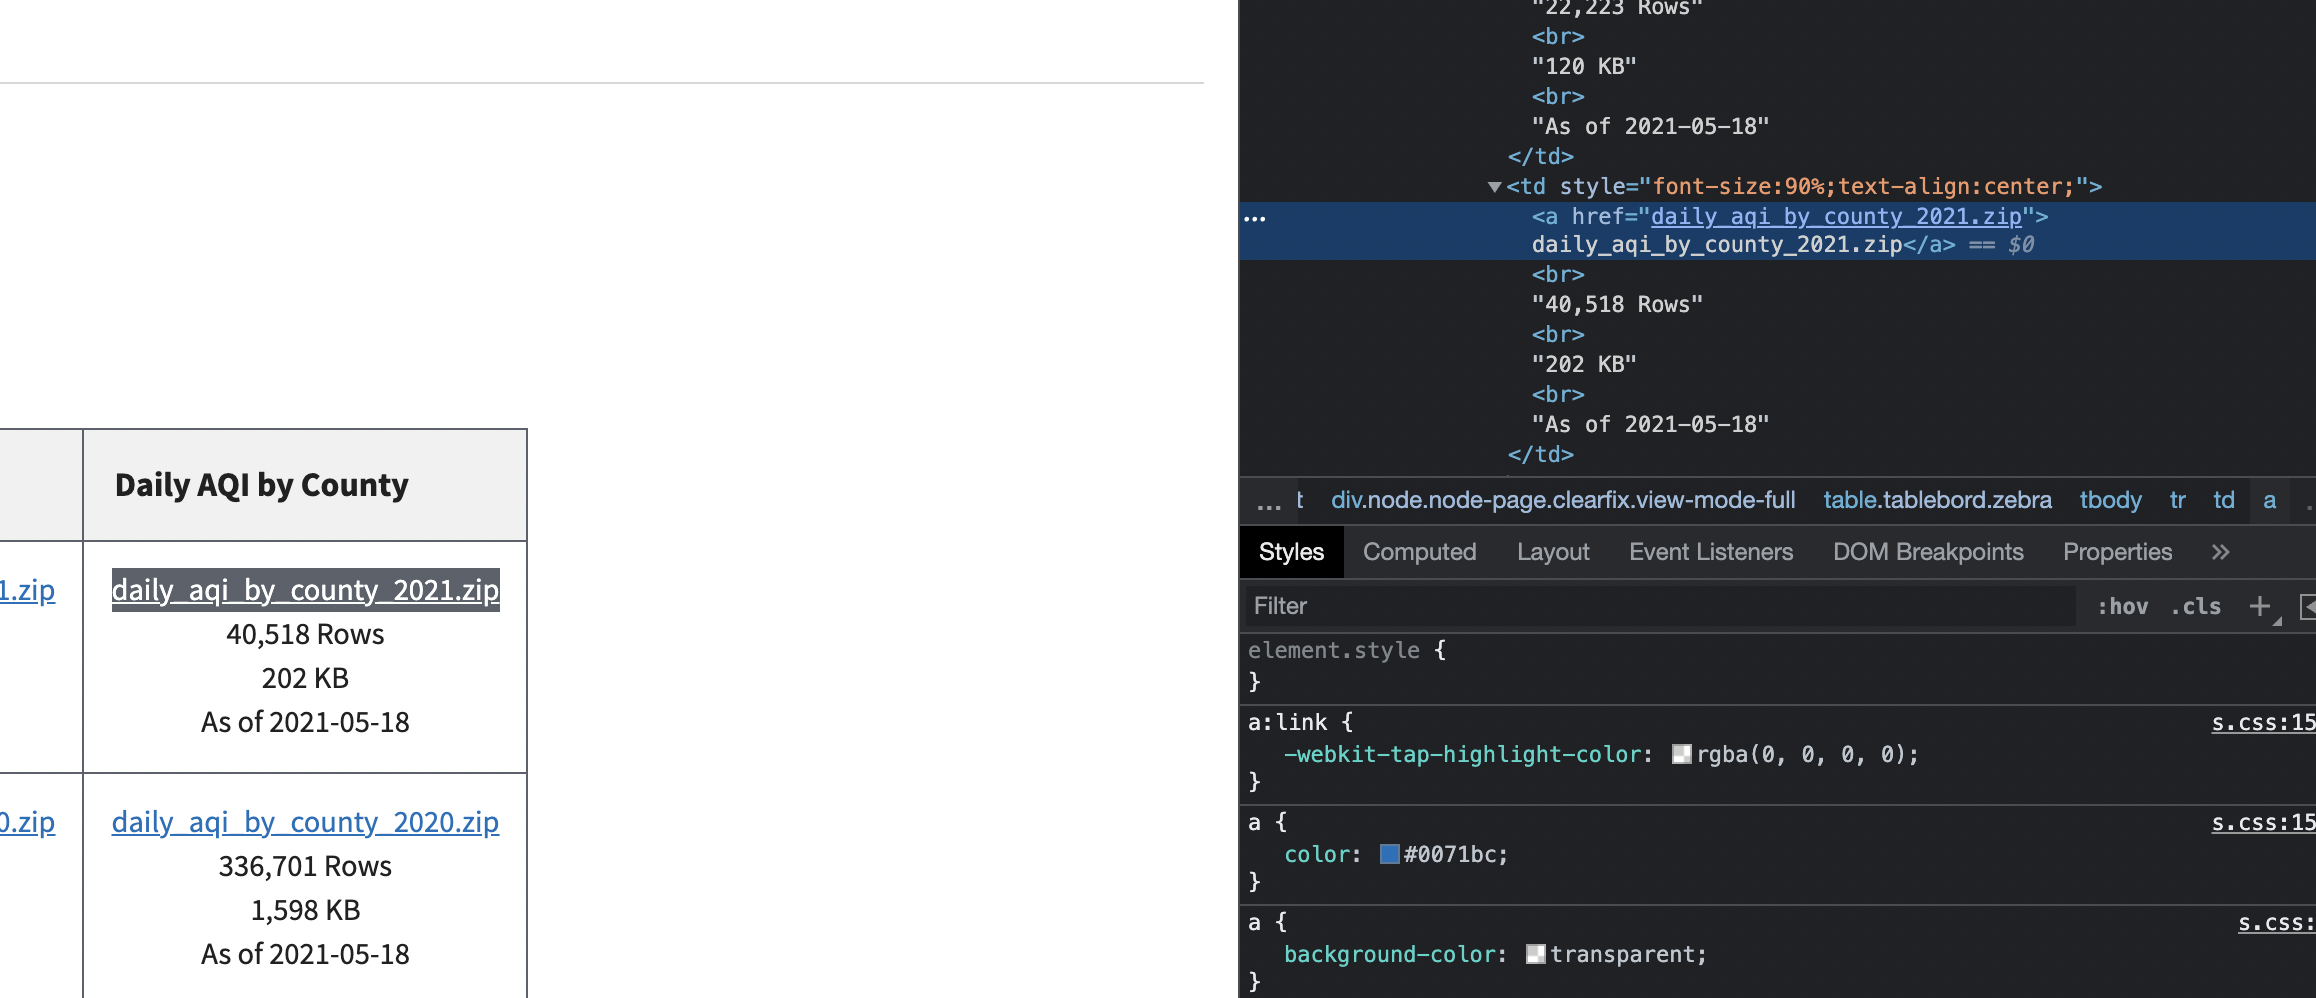

In [3]:
# link to EPA website for pre-generated data files
html_page = requests.get(epa_site)
soup = BeautifulSoup(html_page.content, 'html.parser')

# find all a href links available on this page
file_urls = soup.findAll('a', href=lambda href: href and href.startswith(county_parse))
links = [epa_link+link.get('href') for link in file_urls]
print(links)

['https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2021.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2020.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2019.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2016.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2015.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2014.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2013.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2012.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2011.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2010.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2009.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2008.zip', 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2007.

#### Download, Unzip, and Compile into single df

In [4]:
# initiating a dataframe
county_aqi = pd.DataFrame()

#forloop to download, unzip, and compile df
for link in links:
    
    # open url
    resp = urlopen(link)
    # read zipfile
    zipfile = ZipFile(BytesIO(resp.read()))
    # get the csv file name
    fname = zipfile.namelist()[0]
    # convert to pandas dateframe
    df = pd.read_csv(zipfile.open(fname), dtype=object)
    # close zipfile we don't need
    zipfile.close()
    
    # concatenate dataframes
    county_aqi = pd.concat([county_aqi, df], ignore_index=True, sort=False)
    
    # let me know how much it is completed.
    # print(f'{fname} Completed')

##### Export web scraped data __DO NOT RUN__


In [ ]:
# county_aqi.to_csv('data_raw/aqi_county_df.csv')

#### Import datasets
 - These include subsets of the entire datasets downloaded.
 - Datasets we'll focus on include: 
     - The 'county_aqi' dataset
     - a subset of the CBSA datasets
     - a subset of the monitors in CA, NY-NJ, and UT
 - 

In [6]:
# US daily AQI data from 1980-01-01 to 2021-05-18
cbsa_aqi = pd.read_csv('data_raw/cbsa_sites_df.csv')
monitors = pd.read_csv('data_raw/monitors_CA_NY_UT.csv')

<a id='display'></a> 
### Metadata Display and Basic Visualization

Next, provide some example commands to take a quick look at what is in your dataset. We've done some things along these lines in class by now, but you should include at least one of:

- Metadata display: commands to indicate a) which variables are included in the dataset and their names; b) coordinate information associated with the data variables; c) other important metadata parameters (site names, etc); and d) any important information on missing data
- Basic visualization: a "quick and dirty" plot showing generally what the data look like. Depending on your dataset, this could be either a time series or a map (no fancy coordinate reference system/projection needed yet).

In [9]:
cbsa_aqi.head(2)

,Unnamed: 0,Unnamed: 0.1,CBSA,CBSA Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,14306,14306,"New York-Newark-Jersey City, NY-NJ-PA",35620,2021-01-01,56,Moderate,PM2.5,36-071-0002,24
1,14307,14307,"New York-Newark-Jersey City, NY-NJ-PA",35620,2021-01-02,39,Good,PM2.5,36-061-0135,22


In [10]:
monitors.head(2)

,Unnamed: 0,State Code,County Code,Site Number,Latitude,Longitude,Monitor Type,Defining Site
0,21248,6,1,1,37.87687,-122.266913,UNKNOWN,06-001-0001
1,21249,6,1,1,37.87687,-122.266913,UNKNOWN,06-001-0001


#### Merge Dataframes

In [11]:
cbsa_comb = cbsa_aqi.merge(monitors, on='Defining Site', how='left').drop_duplicates(ignore_index=True)

In [12]:
# format date as datetime
cbsa_comb['Date']=pd.to_datetime(cbsa_comb['Date'], format = '%Y-%m-%d')

# convert Category column to category data type
cbsa_comb['Category']=cbsa_comb.Category.astype('category')

#### Create geodataframe

In [ ]:
# convert to geodataframe
geoms=gpd.points_from_xy(cbsa_comb['Longitude'], cbsa_comb['Latitude'], crs='EPSG:4326')

cbsa_df=gpd.GeoDataFrame(cbsa_comb,geometry=geoms)

<a id='usecases'></a> 
### Use Case Examples

This is the "meat" of the notebook, and what will take the majority of the time to present in class. This section should provide:
1) A plain-text summary (1-2 paragraphs) of the use case example you have chosen: include the target users and audience, and potential applicability. For example, the Week 7 SST exercise might discuss how the state of the ENSO system can be important for seasonal weather forecasts/coral bleaching outlooks, then mention the typical diagnostics associated with ENSO (i.e. identification of El Nino/La Nina events).

2) Markdown and code blocks demonstrating how one walks through the desired use case example. This should be similar to the labs we've done in class: you might want to demonstrate how to isolate a particularly interesting time period, then create an image showing a feature you're interested in, for example.

3) A discussion of the results and how they might be extended on further analysis. For example, we are doing El Nino/La Nina composites in class; a natural extension might be to look at individual events to see what their particular impacts were. Or if there are data quality issues which impact the results, you could discuss how these might be mitigated with additional information/analysis.

Just keep in mind, you'll have roughly 20 minutes for your full presentation, and that goes surprisingly quickly! Probably 2-3 diagnostics is the most you'll be able to get through (you could try practicing with your group members to get a sense of timing).


<a id='binder'></a> 
### Create Binder Environment

The last step is to create a Binder environment for your project, so that we don't have to spend time configuring everyone's environment each time we switch between group presentations. Instructions are below:

 - Assemble all of the data needed in your Github repo: Jupyter notebooks, a README file, and any datasets needed (these should be small, if included within the repo). Larger datasets should be stored on a separate server, and access codes included within the Jupyter notebook as discussed above. 
 
 - Create an _environment_ file: this is a text file which contains information on the packages needed in order to execute your code. The filename should be "environment.yml": an example that you can use for the proper syntax is included in this template repo. To determine which packages to include, you'll probably want to start by displaying the packages loaded in your environment: you can use the command `conda list -n [environment_name]` to get a list.
 
 More information on environment files can be found here:
 https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#

 - Create Binder. Use http://mybinder.org to create a  URL for your notebook Binder (you will need to enter your GitHub repo URL). You can also add a Launch Binder button directly to your GitHub repo, by including the following in your README.md:

```
launch with myBinder
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/<path to your repo>)
```

<a id='references'></a> 
### References

List relevant references. Here are some additional resources on creating professional, shareable notebooks you may find useful:

1. Notebook sharing guidelines from reproducible-science-curriculum: https://reproducible-science-curriculum.github.io/publication-RR-Jupyter/
2. Guide for developing shareable notebooks by Kevin Coakley, SDSC: https://github.com/kevincoakley/sharing-jupyter-notebooks/raw/master/Jupyter-Notebooks-Sharing-Recommendations.pdf
3. Guide for sharing notebooks by Andrea Zonca, SDSC: https://zonca.dev/2020/09/how-to-share-jupyter-notebooks.html
4. Jupyter Notebook Best Practices: https://towardsdatascience.com/jupyter-notebook-best-practices-f430a6ba8c69
5. Introduction to Jupyter templates nbextension: https://towardsdatascience.com/stop-copy-pasting-notebooks-embrace-jupyter-templates-6bd7b6c00b94  
    5.1. Table of Contents (Toc2) readthedocs: https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html  
    5.2. Steps to install toc2: https://stackoverflow.com/questions/23435723/installing-ipython-notebook-table-of-contents
6. Rule A, Birmingham A, Zuniga C, Altintas I, Huang SC, et al. (2019) Ten simple rules for writing and sharing computational analyses in Jupyter Notebooks. PLOS Computational Biology 15(7): e1007007. https://doi.org/10.1371/journal.pcbi.1007007. Supplementary materials: example notebooks (https://github.com/jupyter-guide/ten-rules-jupyter) and tutorial (https://github.com/ISMB-ECCB-2019-Tutorial-AM4/reproducible-computational-workflows)
7. Languages supported by Jupyter kernels: https://github.com/jupyter/jupyter/wiki/Jupyter-kernels
8. EarthCube notebooks presented at EC Annual Meeting 2020: https://www.earthcube.org/notebooks
9. Manage your Python Virtual Environment with Conda: https://towardsdatascience.com/manage-your-python-virtual-environment-with-conda-a0d2934d5195
10. Venv - Creation of Virtual Environments: https://docs.python.org/3/library/venv.html